<a href="https://colab.research.google.com/github/robwil/fastai-deeplearning/blob/master/Flower_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup code

In [2]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

# Loading data

In [0]:
urlFlowers = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers'

In [11]:
# untar_data in fastai didn't work because the above file is actually not gzipped..
# so I loaded instead manually 
untar_data(urlFlowers)

ReadError: ignored

In [0]:
!tar xf data/102flowers.tgz
!mkdir data/102flowers
!mv jpg data/102flowers/

In [17]:
path = Path('data/102flowers')
path_img = path/'jpg'
fnames = get_image_files(path_img)
fnames.sort()
fnames[:5]

[PosixPath('data/102flowers/jpg/image_00001.jpg'),
 PosixPath('data/102flowers/jpg/image_00002.jpg'),
 PosixPath('data/102flowers/jpg/image_00003.jpg'),
 PosixPath('data/102flowers/jpg/image_00004.jpg'),
 PosixPath('data/102flowers/jpg/image_00005.jpg')]

# Label Handling

In [18]:
!curl --output imagelabels.mat http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   502  100   502    0     0    500      0  0:00:01  0:00:01 --:--:--   500


In [0]:
# image labels are in mat format. thanks for https://stackoverflow.com/questions/874461/read-mat-files-in-python
import scipy.io
mat = scipy.io.loadmat('imagelabels.mat')

In [20]:
# But unfortunately they're just numbered... no nice labels. The text labels don't exist on the main site.
len(mat['labels'][0])

8189

In [0]:
import numpy
groups = numpy.unique(mat['labels'][0], return_counts=True)

In [23]:
groups

(array([  1,   2,   3,   4, ...,  99, 100, 101, 102], dtype=uint8),
 array([40, 60, 40, 56, ..., 63, 49, 58, 48]))

In [0]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

# Found a way to get labels by scraping this site: http://zeus.robots.ox.ac.uk/flower_demo/demo_overview?sort=random
html = urlopen('http://zeus.robots.ox.ac.uk/flower_demo/demo_overview?sort=random')
soup = BeautifulSoup(html, 'lxml')



In [25]:
flower_types = {}
for flower_type in soup.find_all('div', attrs={'class': 'result-element'}):
  img_no = int(flower_type.div.a.get('href').replace('oxford102/image_', '').replace('.jpg', '').strip())
  if img_no in flower_types:
    print('found dupe: ' + str(img_no))
  flower_types[img_no] = flower_type.p.get_text().strip()
len(flower_types)

102

In [26]:
number_to_name = {}
for img_no, name in flower_types.items():
#   print(numeric_label, mat['labels'][0][numeric_label], name)
  numeric_label = mat['labels'][0][img_no-1]
  number_to_name[numeric_label] = name
number_to_name

{1: 'Pink Primrose',
 2: 'Hard-leaved Pocket Orchid',
 3: 'Canterbury Bells',
 4: 'Sweet Pea',
 5: 'English Marigold',
 6: 'Tiger Lily',
 7: 'Moon Orchid',
 8: 'Bird of Paradise',
 9: 'Monkshood',
 10: 'Globe Thistle',
 11: 'Snapdragon',
 12: "Colt's Foot",
 13: 'King Protea',
 14: 'Spear Thistle',
 15: 'Yellow Iris',
 16: 'Globe-Flower',
 17: 'Purple Coneflower',
 18: 'Peruvian Lily',
 19: 'Balloon Flower',
 20: 'Giant White Arum Lily',
 21: 'Fire Lily (Glory Lily)',
 22: 'Pincushion Flower',
 23: 'Fritillary',
 24: 'Red Ginger',
 25: 'Grape Hyacinth',
 26: 'Corn Poppy',
 27: "Prince of Wales' Feathers",
 28: 'Stemless Gentian',
 29: 'Artichoke',
 30: 'Sweet William',
 31: 'Carnation',
 32: 'Garden Phlox',
 33: 'Love in the Mist',
 34: 'Mexican Aster',
 35: 'Alpine Sea Holly',
 36: 'Ruby-lipped Cattleya',
 37: 'Cape Flower',
 38: 'Great Masterwort',
 39: 'Siam Tulip',
 40: 'Lenten Rose',
 41: 'Barbeton Daisy',
 42: 'Daffodil',
 43: 'Sword Lily',
 44: 'Poinsettia',
 45: 'Bolero Deep Bl

In [0]:
labels = []
for label in mat['labels'][0]:
  labels.append(number_to_name[label])

# Load image data into ImageDataBunch

In [0]:
data = ImageDataBunch.from_lists(path, fnames, labels=labels, ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)


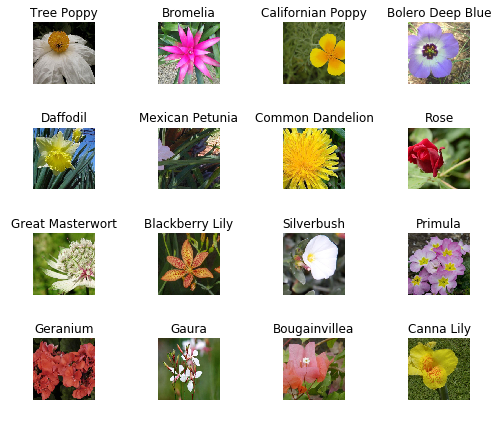

In [29]:
data.show_batch(rows=4, figsize=(7,6))

In [30]:
print(data.classes)
len(data.classes),data.c

['Alpine Sea Holly', 'Anthurium', 'Artichoke', 'Azalea', 'Ball Moss', 'Balloon Flower', 'Barbeton Daisy', 'Bearded Iris', 'Bee Balm', 'Bird of Paradise', 'Bishop of Llandaff', 'Black-eyed Susan', 'Blackberry Lily', 'Blanket Flower', 'Bolero Deep Blue', 'Bougainvillea', 'Bromelia', 'Buttercup', 'Californian Poppy', 'Camellia', 'Canna Lily', 'Canterbury Bells', 'Cape Flower', 'Carnation', 'Cautleya Spicata', 'Clematis', "Colt's Foot", 'Columbine', 'Common Dandelion', 'Corn Poppy', 'Cyclamen', 'Daffodil', 'Desert-rose', 'English Marigold', 'Fire Lily (Glory Lily)', 'Foxglove', 'Frangipani', 'Fritillary', 'Garden Phlox', 'Gaura', 'Gazania', 'Geranium', 'Giant White Arum Lily', 'Globe Thistle', 'Globe-Flower', 'Grape Hyacinth', 'Great Masterwort', 'Hard-leaved Pocket Orchid', 'Hibiscus', 'Hippeastrum', 'Japanese Anemone', 'King Protea', 'Lenten Rose', 'Lotus', 'Love in the Mist', 'Magnolia', 'Mallow', 'Marigold', 'Mexican Aster', 'Mexican Petunia', 'Monkshood', 'Moon Orchid', 'Morning Glory

(102, 102)

# Training - first pass

In [31]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 112351253.31it/s]


In [0]:
learn.model_dir = base_dir + '/models/flowers'

In [115]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.724279,0.936707,0.196701,02:57
1,0.904186,0.276373,0.058644,02:58
2,0.402163,0.193089,0.047648,02:59
3,0.254376,0.180869,0.043983,02:59


In [0]:
learn.save('stage-1')

In [117]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

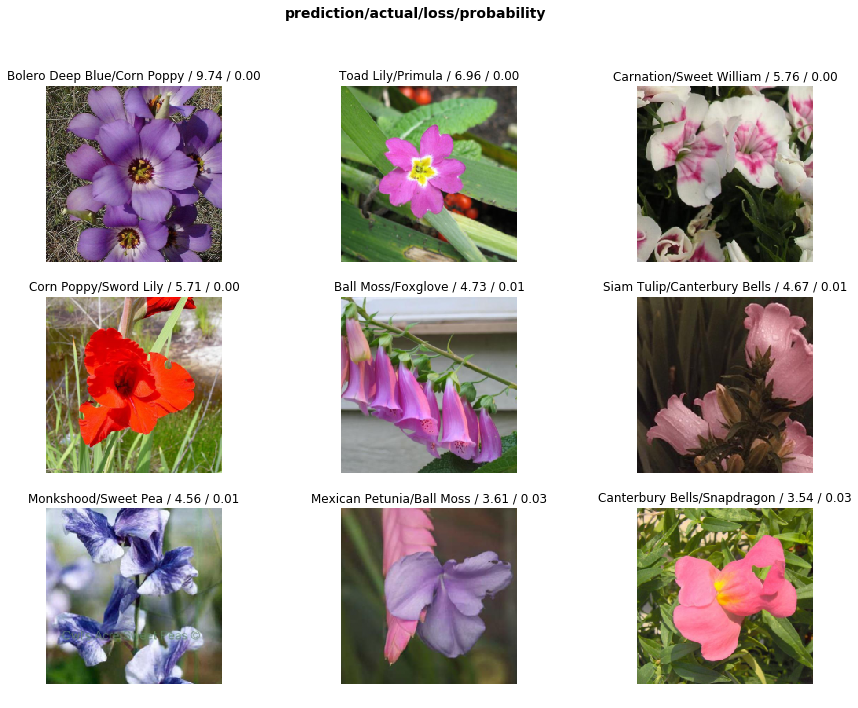

In [118]:
interp.plot_top_losses(9, figsize=(15,11))

In [120]:
interp.most_confused(min_val=2)

[("Colt's Foot", 'Common Dandelion', 2),
 ('Snapdragon', 'Canterbury Bells', 2),
 ('Sweet William', 'Carnation', 2)]

# Fine tuning

In [0]:
learn.unfreeze()

In [122]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.442717,0.164865,0.042761,03:00


In [123]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


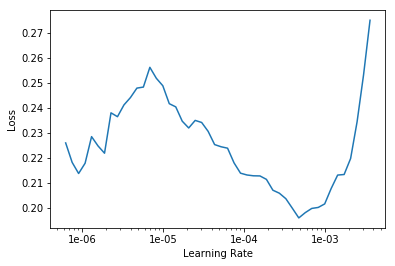

In [124]:
learn.recorder.plot()

In [126]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.160919,0.101025,0.023824,03:02
1,0.110687,0.087808,0.023824,02:59


In [125]:
learn.validate(metrics=[error_rate])

[0.1648654, tensor(0.0428)]

In [0]:
learn.save('stage-2')

# ResNet50

In [33]:
data = ImageDataBunch.from_lists(path, fnames, labels=labels, ds_tfms=get_transforms(), size=299, bs=bs//2).normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.model_dir = base_dir + '/models/flowers'

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 107179524.68it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


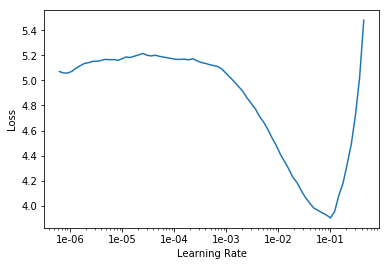

In [34]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.673809,14.692594,0.045205,03:50
1,0.470422,32.994427,0.050092,03:49
2,0.518805,64.681007,0.047648,03:55
3,0.383572,83.914490,0.057422,03:53
4,0.392706,30.341145,0.052535,03:55
5,0.421573,20.174335,0.048259,03:51
6,0.328010,24.819515,0.048259,03:48
7,0.233975,24.403458,0.045816,03:48


In [0]:
learn.save('stage-1-50')

In [42]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-3,1e-1))

epoch,train_loss,valid_loss,error_rate,time
0,12.665124,3675.147949,0.962126,05:00
1,7.671886,63954.937500,0.863164,04:57
2,3.821567,184120.000000,0.679291,04:58


In [0]:
learn.save('stage-2-50')

In [44]:
learn.validate(metrics=[error_rate])

[184120.0, tensor(0.6793)]

In [45]:
learn.load('stage-1-50')

Learner(data=ImageDataBunch;

Train: LabelList (6552 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Passion Flower,Passion Flower,Passion Flower,Passion Flower,Passion Flower
Path: data/102flowers;

Valid: LabelList (1637 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Bromelia,Clematis,Morning Glory,Camellia,Cyclamen
Path: data/102flowers;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2

In [46]:
learn.validate(metrics=[error_rate])

[24.403458, tensor(0.0458)]

ResNet 50 results is worse than ResNet 34. This shouldn't really be the case, so I'm going to try training ResNet 50 again with the same size=224 parameter (instead of 299). Admittedly I don't know what that size param even does.

In [0]:
data = ImageDataBunch.from_lists(path, fnames, labels=labels, ds_tfms=get_transforms(), size=224, bs=bs//2).normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.model_dir = base_dir + '/models/flowers'

In [48]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.791669,0.769470,0.133170,04:03
1,0.632157,0.299993,0.080024,03:56
2,0.417066,0.194023,0.055589,03:57
3,0.269148,0.165447,0.045816,03:56
4,0.170866,0.125943,0.038485,03:54
5,0.103047,0.113189,0.032987,03:53
6,0.079280,0.104075,0.031155,03:55
7,0.063147,0.097850,0.029322,03:54


In [0]:
learn.save('stage-1-50-224')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


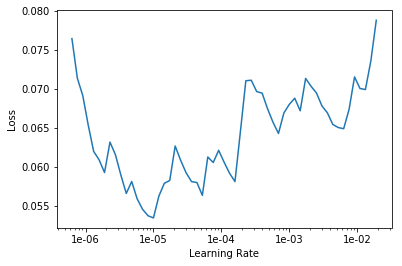

In [50]:
learn.lr_find()
learn.recorder.plot()

In [51]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.056263,0.094976,0.027489,04:08
1,0.062720,0.091619,0.029322,04:07


In [0]:
learn.save('stage-2-50-224')

This result is getting better, but still not as good as ResNet34. Will give up for now..